In [4]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    RocCurveDisplay, auc, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix, classification_report,
    balanced_accuracy_score, roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay
import scipy


pd.set_option('display.max_columns', None)

sys.path.append(os.path.abspath("../src"))  

my_analysis_path = '/home/gus/Documents/REPOS/tmt-analysis/data/hand_analysis/2025-05-16_15-31-02/metrics.csv'
metadata_path = '../data/metadata/metadata.csv'

df = pd.read_csv(my_analysis_path)

In [5]:
df['is_valid'].value_counts(dropna=False)

is_valid
True     1879
False     101
Name: count, dtype: int64

In [6]:
df.groupby(['subject_id', 'trial_type'])['is_valid'].sum().reset_index()

,subject_id,trial_type,is_valid
0,1,PART_A,10
1,1,PART_B,10
2,2,PART_A,10
3,2,PART_B,9
4,3,PART_A,10
...,...,...,...
193,97,PART_B,10
194,98,PART_A,8
195,98,PART_B,9
196,99,PART_A,10


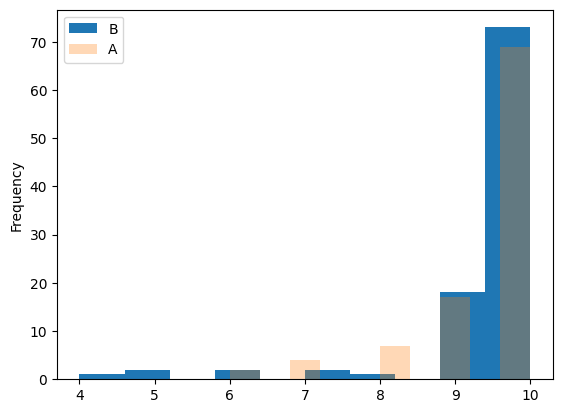

In [7]:
df_grouped = df.groupby(['subject_id', 'trial_type'])['is_valid'].sum().reset_index()
df_grouped[df_grouped['trial_type'] == 'PART_B']['is_valid'].plot(kind="hist")
df_grouped[df_grouped['trial_type'] == 'PART_A']['is_valid'].plot(kind="hist", alpha=0.3)
plt.legend(['B', 'A'])
df_grouped

# Pivot to have PART_A and PART_B sums in separate columns
df_pivot = df_grouped.pivot(index='subject_id', columns='trial_type', values='is_valid').reset_index()
df_pivot.columns = ['subject_id', 'is_valid_sum_A', 'is_valid_sum_B']

df = df.merge(df_pivot, on='subject_id')
df['is_valid_sum_A'] = (df['is_valid_sum_A'] / 10) * 100
df['is_valid_sum_B'] = (df['is_valid_sum_B'] / 10) * 100


In [8]:
def clean_metadata(path_to_metadata):
    df = (
    (
        pd.read_csv(path_to_metadata)
        .rename(
            columns={
                "Anteojos o lentes de contacto": "glasses",
                "Años de escolaridad": "years_of_education",
                "MMSE / 30": "MMSE",
                "Reloj / 3": "clock_drawing_test",
                "Nro de participante": "suj",
                "Género": "sex",
                "Edad": "age",
                "Grupo": "group",
                "TMT A papel PB": "tmt_a_raw",
                "TMT B papel PB": "tmt_b_raw",
                "Digit Symbol pb": "digit_symbol_raw",
                "Span directo pb": "forward_digit_span_raw",
                "span inverso pb": "backward_digit_span_raw",
                "reloj": "clock_drawing_test",
                'TMT A (papel) Z': 'tmt_a_z',
                'TMT B (papel) Z': 'tmt_b_z',
                'Digit - symbol Z': 'digit_symbol_z',
                'Span directo Z': 'forward_digit_span_z',
                'Span inverso z': 'backward_digit_span_z'
            }
        )
        .replace("Caso ?", "Caso")
    )
    .drop([0, 1])
    .reset_index(drop=True) 
    )  # 0 and 1 are summary

    df.columns = [x.lower() for x in df.columns]
    print(df.columns)
    df = df.replace(",", ".", regex=True)
    df["sex"] = df["sex"].replace({"F": 1, "M": 0}).astype("Int64")
    df["group"] = df["group"].str.lower()
    df = df.replace("caso", "mci")
    df = df.replace("Suspendido", 300).replace("No logra", 300)  # 300 seconds it is the max time based on the literature
    df['digit_symbol_raw'] = df['digit_symbol_raw'].replace('no se lo administraron', np.nan).astype(float)
    df['digit_symbol_z'] = df['digit_symbol_z'].replace('pendiente', np.nan).astype(float)
    df = df.astype({"tmt_a_raw": float, "tmt_b_raw": float})
    df["suj"] = df["suj"].astype(int)
    return df

In [9]:
df_metadata_complete = pd.read_csv(metadata_path)
df_metadata_complete.columns
# [col for col in df_metadata_complete.columns if col.endswith(('z', 'Z'))]


Index(['Nro de participante', 'Grupo', 'Clasificación de caso',
       'Comentario (tipo de caso o criterio de exclusión)', 'ID participante',
       'Fecha', 'Hora', 'Neuropsicol.', 'EyeTracker', 'Género', 'Edad',
       'Anteojos o lentes de contacto', 'Observaciones', 'MMSE / 30',
       'MMSE Fallas', 'TMT A papel PB', 'TMT A (papel) Z', 'TMT B papel PB',
       'TMT B papel errores', 'TMT B (papel) Z', 'Digit Symbol pb',
       'Digit - symbol Z', 'Span directo pb', 'Span directo Z',
       'span inverso pb', 'Span inverso z', 'Reloj / 3',
       'Años de escolaridad'],
      dtype='object')

In [10]:
df_metadata = clean_metadata(metadata_path)
df_metadata


Index(['suj', 'group', 'clasificación de caso',
       'comentario (tipo de caso o criterio de exclusión)', 'id participante',
       'fecha', 'hora', 'neuropsicol.', 'eyetracker', 'sex', 'age', 'glasses',
       'observaciones', 'mmse', 'mmse fallas', 'tmt_a_raw', 'tmt_a_z',
       'tmt_b_raw', 'tmt b papel errores', 'tmt_b_z', 'digit_symbol_raw',
       'digit_symbol_z', 'forward_digit_span_raw', 'forward_digit_span_z',
       'backward_digit_span_raw', 'backward_digit_span_z',
       'clock_drawing_test', 'years_of_education'],
      dtype='object')


,suj,group,clasificación de caso,comentario (tipo de caso o criterio de exclusión),id participante,fecha,hora,neuropsicol.,eyetracker,sex,age,glasses,observaciones,mmse,mmse fallas,tmt_a_raw,tmt_a_z,tmt_b_raw,tmt b papel errores,tmt_b_z,digit_symbol_raw,digit_symbol_z,forward_digit_span_raw,forward_digit_span_z,backward_digit_span_raw,backward_digit_span_z,clock_drawing_test,years_of_education
0,1,control,NaN,*,946462,22/1/2024,14:30,Betsabé,Gus,1,52,-,No trajo los lentes para ver de cerca,30.0,--,32.00,0.37,47.00,NaN,1.36,63.0,0.00,6.0,-0.17,4.0,-0.60,2.0,18.0
1,2,control,NaN,*,2684844,22/1/2024,15:00,Betsabé,Gus,0,78,Anteojos,NaN,28.0,-2 recuerdo,47.00,0.36,82.00,NaN,0.85,36.0,0.67,6.0,0.07,5.0,0.5,3.0,16.0
2,3,mci,DCL MD no amnesico,NaN,6305,22/1/2024,15:30,Laura,Gus,1,68,Anteojos,NaN,28.0,-2 atención,65.00,-0.38,107.00,NaN,0.40,45.0,0.33,5.0,0.64,4.0,0.21,3.0,12.0
3,4,mci,DCL MD no amnesico,NaN,2060316,22/1/2024,16:00,Laura,Gus,1,80,Anteojos,NaN,28.0,-1 atención. -1 recuerdo,55.00,0.03,109.00,NaN,0.36,38.0,1.33,5.0,-0.64,4.0,-0.21,3.0,15.0
4,5,mci,DCL MD no amnesico,NaN,4744,22/1/2024,16:30,Betsabé,Gus,1,87,Anteojos,NaN,25.0,-2 OT. -1 At. -1 rec. -1VC,63.00,-0.29,180.09,(2 errores),-0.92,32.0,0.00,5.0,-0.64,3.0,-0.93,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,97,mci,DCL no amnesico,NaN,2302423,7/10/2024,13hs,Betsabe,Alejandro,1,75,anteojos,NaN,27.0,1 atenc. 2 recuerdo,38.90,0.69,93.70,2 errores,0.64,28.0,0.00,7.0,1.58,4.0,0.80,3.0,12.0
96,98,mci,DCL no amnesico,NaN,3104154,21/10/2024,13hs,Betsabe,Alejandro,1,70,anteojos,NaN,29.0,1 recuerdo,40.36,-0.63,140.00,4 errores,0.19,46.0,1.00,5.0,-0.08,4.0,0.80,3.0,15.0
97,99,mci,DCL no amnesico,NaN,2486596,21/10/2024,1:15:00 p.m.,Betsabe,Alejandro,1,71,NaN,NaN,29.0,1 recuerdo,51.80,0.16,78.30,NaN,0.92,42.0,0.67,6.0,0.75,6.0,2.80,3.0,18.0
98,100,control,NaN,NaN,22945,11/11/2024,13hs,Betsabe,Alejandro,0,76,anteojos,NaN,29.0,1 VC,50.42,0.22,69.40,-,1.08,40.0,0.67,8.0,2.42,5.0,1.80,3.0,18.0


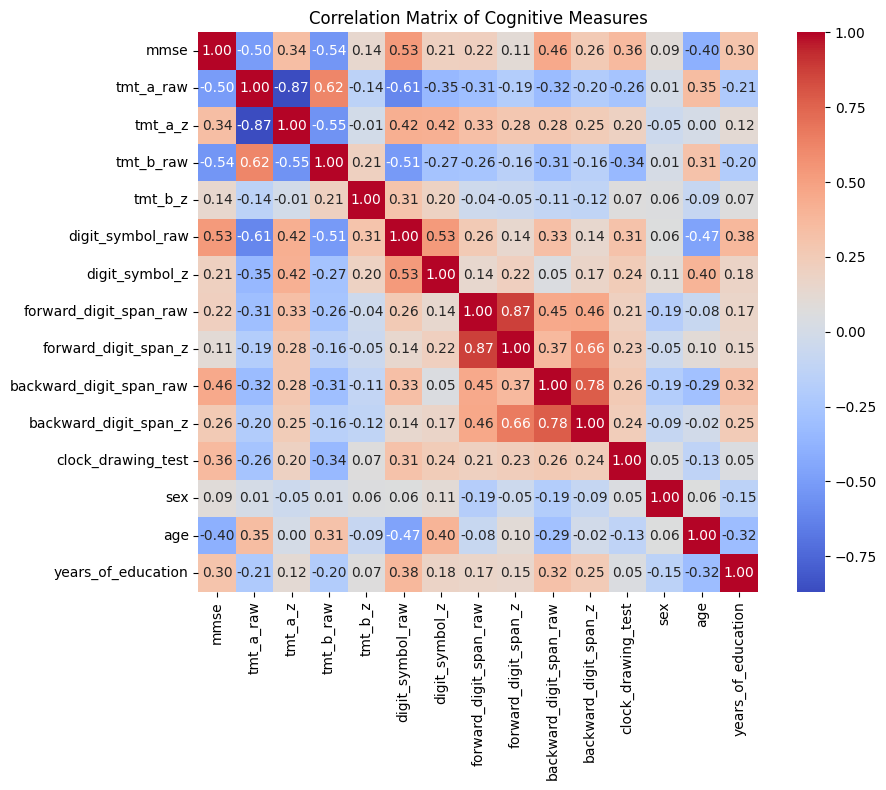

In [11]:
# Clean and convert appropriate columns to numeric
cognitive_columns = ['mmse','tmt_a_raw', 'tmt_a_z',
                    'tmt_b_raw', 'tmt_b_z', 'digit_symbol_raw',
                    'digit_symbol_z', 'forward_digit_span_raw', 'forward_digit_span_z',
                    'backward_digit_span_raw', 'backward_digit_span_z',
                    'clock_drawing_test',]

demographic_colums = ['sex', 'age','years_of_education']

group_column = ['group']

df_metadata_cognitive = df_metadata[['suj','group'] + demographic_colums + cognitive_columns].copy()

df_all = df.merge(df_metadata_cognitive, left_on='subject_id', right_on='suj').rename(columns={"sex_y": "sex", "age_y": "age", "group_y": "group"})
keep_cols = [i for i in df_all.columns if "_x" not in i]
df_all = df_all[keep_cols]

# Compute correlation matrix
corr_matrix = df_metadata[cognitive_columns + demographic_colums].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Cognitive Measures")
plt.tight_layout()
plt.show()

In [12]:
demographic_colums

['sex', 'age', 'years_of_education']

In [13]:
df_metadata_cognitive.sort_values('age')

,suj,group,sex,age,years_of_education,mmse,tmt_a_raw,tmt_a_z,tmt_b_raw,tmt_b_z,digit_symbol_raw,digit_symbol_z,forward_digit_span_raw,forward_digit_span_z,backward_digit_span_raw,backward_digit_span_z,clock_drawing_test
31,32,control,0,25,NaN,29.0,51.70,-2.18,75.00,-0.14,60.0,-1.00,5.0,-1.42,5.0,-0.07,3.0
43,44,control,1,50,18.0,28.0,38.05,-0.17,96.12,-0.38,48.0,-0.67,6.0,-0.17,4.0,-0.6,3.0
72,74,control,1,50,15.0,27.0,28.44,0.68,84.54,0.03,61.0,0.00,7.0,0.79,4.0,-0.21,2.0
36,37,control,1,51,18.0,30.0,40.84,-0.42,74.04,0.40,75.0,0.67,6.0,-0.17,5.0,0.4,3.0
0,1,control,1,52,18.0,30.0,32.00,0.37,47.00,1.36,63.0,0.00,6.0,-0.17,4.0,-0.60,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,56,control,0,86,18.0,28.0,23.29,1.33,51.22,1.41,58.0,2.67,7.0,0.79,5.0,0.5,3.0
45,46,mci,1,86,12.0,28.0,61.26,-0.22,107.41,0.39,32.0,1.33,5.0,-0.64,3.0,-0.93,3.0
4,5,mci,1,87,10.0,25.0,63.00,-0.29,180.09,-0.92,32.0,0.00,5.0,-0.64,3.0,-0.93,1.0
89,91,control,1,90,7.0,27.0,61.78,-0.24,169.00,-0.72,25.0,0.67,5.0,-0.64,4.0,-0.21,3.0


In [54]:
mci = df_metadata_cognitive[df_metadata_cognitive['group'] == 'mci']
mci[mci['age'] <= 55]

,suj,group,sex,age,years_of_education,mmse,tmt_a_raw,tmt_a_z,tmt_b_raw,tmt_b_z,digit_symbol_raw,digit_symbol_z,forward_digit_span_raw,forward_digit_span_z,backward_digit_span_raw,backward_digit_span_z,clock_drawing_test
74,76,mci,1,52,15.0,27.0,35.02,0.10,76.34,0.32,57.0,-0.33,6.0,-0.17,5.0,0.40,3.0


In [108]:
min_age = 51

metadata_control = df_metadata_cognitive[df_metadata_cognitive['group'] == 'control']
metadata_control = metadata_control[metadata_control['age'] >= min_age]
metadata_mci = df_metadata_cognitive[df_metadata_cognitive['group'] == 'mci']
metadata_mci = metadata_mci[metadata_mci['age'] >= min_age]

for var in demographic_colums:
    if var == "sex":
        # Combine these lists into a 2x2 contingency table
        # Count occurrences of each category (1 = Female, 0 = Male) in each group
        mci_counts = Counter(metadata_mci["sex"])
        control_counts = Counter(metadata_control["sex"])

        # Create the contingency table
        contingency_table = [
            [mci_counts[1], control_counts[1]],  # Female counts  (mci and control)
            [mci_counts[0], control_counts[0]],  # Male counts (mci and control)
        ]
        # Perform Chi-square test
        chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)
        print(f"chi2: {var}, p={p:.3f}")
        continue
    t_stat, p_value = scipy.stats.ttest_ind(
        metadata_mci[var], metadata_control[var], nan_policy="omit"
    )
    print(f"T-test: {var}, p={p_value:.5f}")


print(len(metadata_control))
print(len(metadata_mci))

chi2: sex, p=0.672
T-test: age, p=0.09681
T-test: years_of_education, p=0.23728
42
55


In [15]:
# metadata_control = df_metadata_cognitive[df_metadata_cognitive['group'] == 'control']
metadata_mci[metadata_mci['age'] <= 60]

,suj,group,sex,age,years_of_education,mmse,tmt_a_raw,tmt_a_z,tmt_b_raw,tmt_b_z,digit_symbol_raw,digit_symbol_z,forward_digit_span_raw,forward_digit_span_z,backward_digit_span_raw,backward_digit_span_z,clock_drawing_test
53,54,mci,1,57,20.0,30.0,43.0,-0.62,67.0,0.65,56.0,0.33,5.0,-0.64,4.0,-0.21,3.0
54,55,mci,1,60,17.0,28.0,27.0,0.81,92.0,-0.24,45.0,-0.33,5.0,-0.64,4.0,-0.21,3.0


<Axes: ylabel='Frequency'>

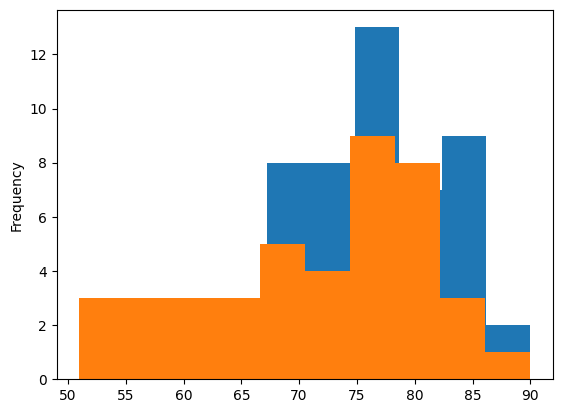

In [63]:
metadata_mci['age'].plot(kind='hist')
metadata_control['age'].plot(kind='hist')

In [109]:
min_age = 51
df = df_all.copy()

df_valid = df[df["is_valid"]]

# df_valid = df_valid[df_valid['age'] >= min_age]

valid_counts = df_valid.groupby(['subject_id', 'trial_type']).size().unstack(fill_value=0)

# subjects_with_enough_valid_trials = valid_counts[
#     (valid_counts.get('PART_A', 0) >= 2) & (valid_counts.get('PART_B', 0) >= 2)
# ].index

# df_valid = df_valid[df_valid['subject_id'].isin(subjects_with_enough_valid_trials)]

subjects_final_set = list(df_valid['subject_id'].unique())

digital_tmt_vars = [
    'speed_threshold', 'total_distance', 'rt',
       'correct_targets_touches', 'wrong_targets_touches', 'mean_speed',
       'std_speed', 'peak_speed', 'mean_acceleration', 'std_acceleration',
       'peak_acceleration', 'mean_abs_acceleration', 'std_abs_acceleration',
       'peak_abs_acceleration', 'mean_negative_acceleration',
       'std_negative_acceleration', 'peak_negative_acceleration',
       'hesitation_time', 'travel_time', 'search_time', 'hesitation_distance',
       'travel_distance', 'search_distance', 'hesitation_avg_speed',
       'travel_avg_speed', 'search_avg_speed', 'state_transitions',
       'hesitation_ratio', 'total_hesitations', 'average_duration',
       'max_duration','zigzag_amplitude', 'distance_difference_from_ideal', 
       'area_difference_from_ideal',
]

non_digital_vars = ['mmse', 'tmt_a_raw',
                    'tmt_a_z', 'tmt_b_raw', 'tmt_b_z', 'digit_symbol_raw', 'digit_symbol_z',
                    'forward_digit_span_raw', 'forward_digit_span_z',
                    'backward_digit_span_raw', 'backward_digit_span_z',
                    'clock_drawing_test']


df_digital_tmt = df_valid.pivot_table(index='subject_id', columns="trial_type", values=digital_tmt_vars)

df_digital_tmt.columns = [f"{var}_{ttype}" for var, ttype in df_digital_tmt.columns]


df_digital_tmt = df_valid.pivot_table(index='subject_id', columns="trial_type", values=digital_tmt_vars)

df_digital_tmt.columns = [f"{var}_{ttype}" for var, ttype in df_digital_tmt.columns]
df_digital_tmt = df_digital_tmt.reset_index(names='suj')
df_digital_tmt = df_digital_tmt[df_digital_tmt['suj'].isin(subjects_final_set)]
df_digital_tmt_with_target = df_digital_tmt.merge(df_metadata_cognitive[['suj'] + ['group']], on='suj').set_index('suj')
df_digital_tmt_with_target['group'] = df_digital_tmt_with_target['group'].str.replace('mci', '1').replace('control', '0').astype(int)


demographic_df = df_metadata_cognitive[['suj', 'sex', 'age', 'years_of_education','group']].copy()
demographic_df['group'] = demographic_df['group'].str.replace('mci', '1').replace('control', '0').astype(int)
demographic_df = demographic_df[demographic_df['suj'].isin(subjects_final_set)].set_index('suj')



non_digital_df = df_metadata_cognitive[['suj'] + non_digital_vars + ['group']].copy()
non_digital_df['group'] = non_digital_df['group'].str.replace('mci', '1').replace('control', '0').astype(int)
non_digital_df = non_digital_df[non_digital_df['suj'].isin(subjects_final_set)].set_index('suj')


# Check
print(df_digital_tmt_with_target['group'].value_counts())
print(demographic_df['group'].value_counts())
print(non_digital_df['group'].value_counts())

group
1    55
0    43
Name: count, dtype: int64
group
1    55
0    43
Name: count, dtype: int64
group
1    55
0    43
Name: count, dtype: int64


dataset: demographic
Class distribution: {0: 43, 1: 55}

🧪 Nested CV for: RandomForestClassifier
Fitting 3 folds for each of 16 candidates, totalling 48 fits


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits


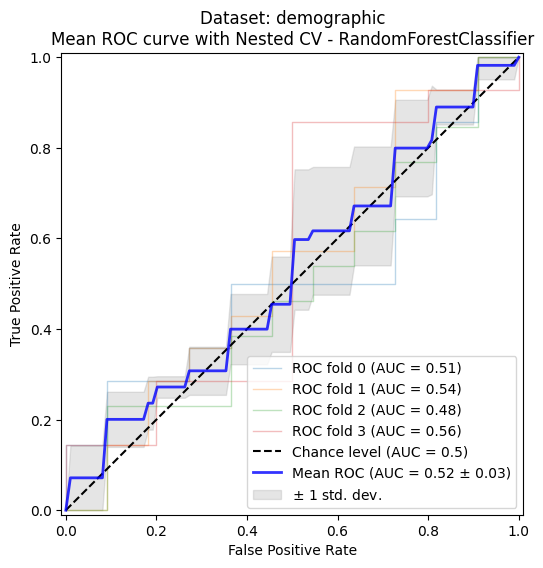

🔧 Best hyperparameters across folds for RandomForestClassifier:
  Fold 0: {'classifier__max_depth': 10, 'classifier__n_estimators': 700}
  Fold 1: {'classifier__max_depth': None, 'classifier__n_estimators': 500}
  Fold 2: {'classifier__max_depth': None, 'classifier__n_estimators': 1000}
  Fold 3: {'classifier__max_depth': None, 'classifier__n_estimators': 500}
🔢 Global Confusion Matrix (all folds combined):
[[17 26]
 [25 30]]


<Figure size 600x500 with 0 Axes>

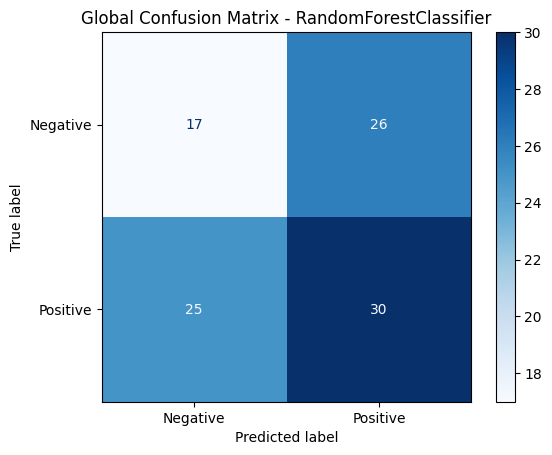

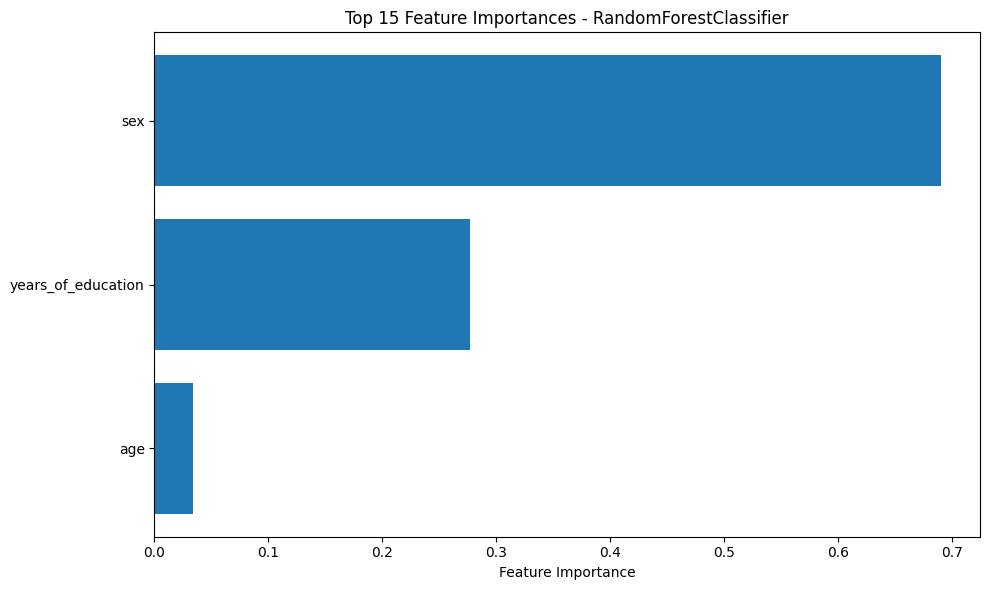


🧪 Nested CV for: SVC
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


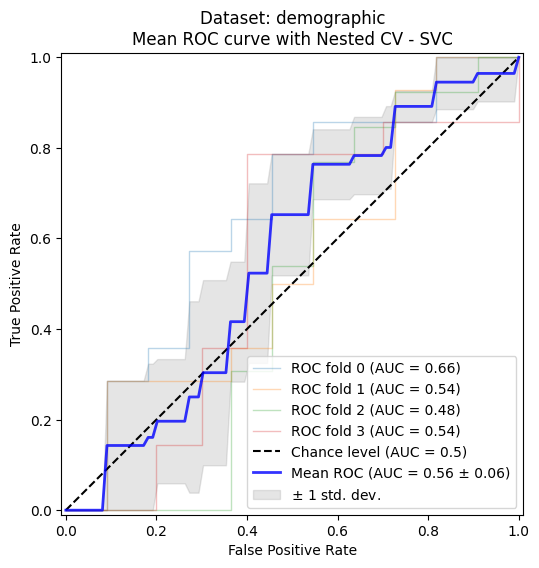

🔧 Best hyperparameters across folds for SVC:
  Fold 0: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
  Fold 1: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
  Fold 2: {'classifier__C': 1, 'classifier__kernel': 'linear'}
  Fold 3: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
🔢 Global Confusion Matrix (all folds combined):
[[15 28]
 [14 41]]


<Figure size 600x500 with 0 Axes>

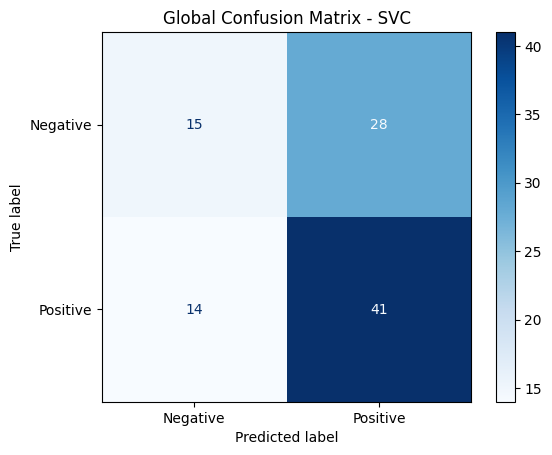


🧪 Nested CV for: LogisticRegression
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits


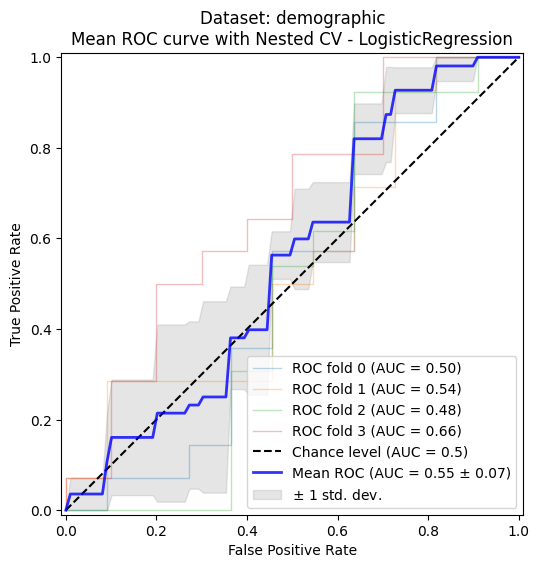

🔧 Best hyperparameters across folds for LogisticRegression:
  Fold 0: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
  Fold 1: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
  Fold 2: {'classifier__C': 10, 'classifier__penalty': 'l2'}
  Fold 3: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
🔢 Global Confusion Matrix (all folds combined):
[[14 29]
 [11 44]]


<Figure size 600x500 with 0 Axes>

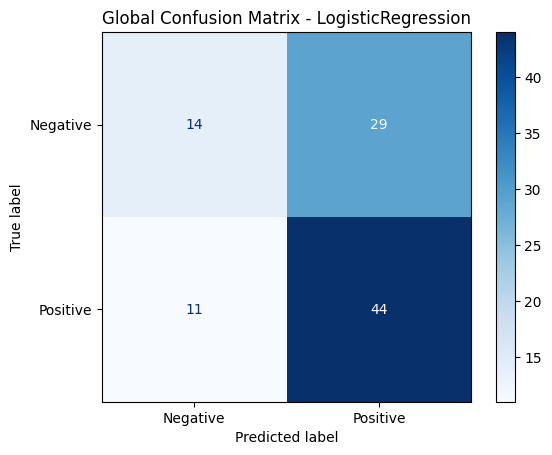


🧪 Nested CV for: XGBClassifier
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


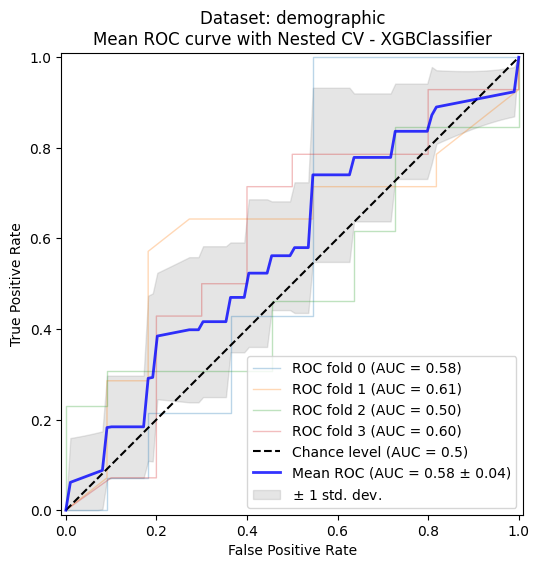

🔧 Best hyperparameters across folds for XGBClassifier:
  Fold 0: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
  Fold 1: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
  Fold 2: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 300}
  Fold 3: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
🔢 Global Confusion Matrix (all folds combined):
[[20 23]
 [20 35]]


<Figure size 600x500 with 0 Axes>

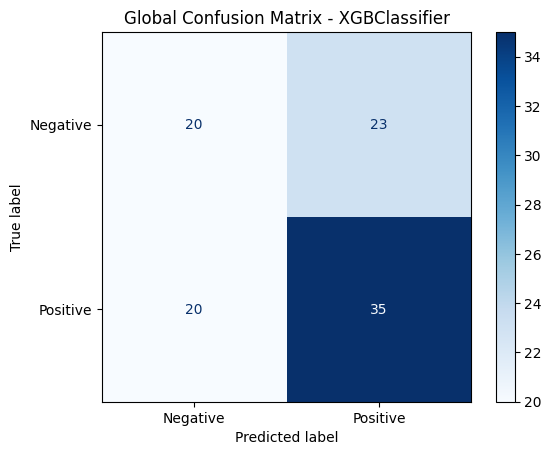


🏆 Model Performance Comparison:

ACCURACY:
  LogisticRegression: 0.592 ± 0.099
  RandomForestClassifier: 0.480 ± 0.064
  SVC: 0.571 ± 0.053
  XGBClassifier: 0.561 ± 0.085

BALANCED_ACCURACY:
  LogisticRegression: 0.560 ± 0.074
  RandomForestClassifier: 0.472 ± 0.067
  SVC: 0.550 ± 0.041
  XGBClassifier: 0.551 ± 0.084

PRECISION:
  LogisticRegression: 0.594 ± 0.056
  RandomForestClassifier: 0.538 ± 0.067
  SVC: 0.597 ± 0.034
  XGBClassifier: 0.604 ± 0.088

RECALL:
  LogisticRegression: 0.795 ± 0.240
  RandomForestClassifier: 0.545 ± 0.034
  SVC: 0.746 ± 0.205
  XGBClassifier: 0.635 ± 0.072

F1:
  LogisticRegression: 0.674 ± 0.125
  RandomForestClassifier: 0.541 ± 0.050
  SVC: 0.652 ± 0.082
  XGBClassifier: 0.619 ± 0.080

AUC:
  LogisticRegression: 0.545 ± 0.084
  RandomForestClassifier: 0.521 ± 0.033
  SVC: 0.555 ± 0.073
  XGBClassifier: 0.572 ± 0.048

SPECIFICITY:
  LogisticRegression: 0.325 ± 0.115
  RandomForestClassifier: 0.398 ± 0.101
  SVC: 0.355 ± 0.180
  XGBClassifier: 0.468 ± 

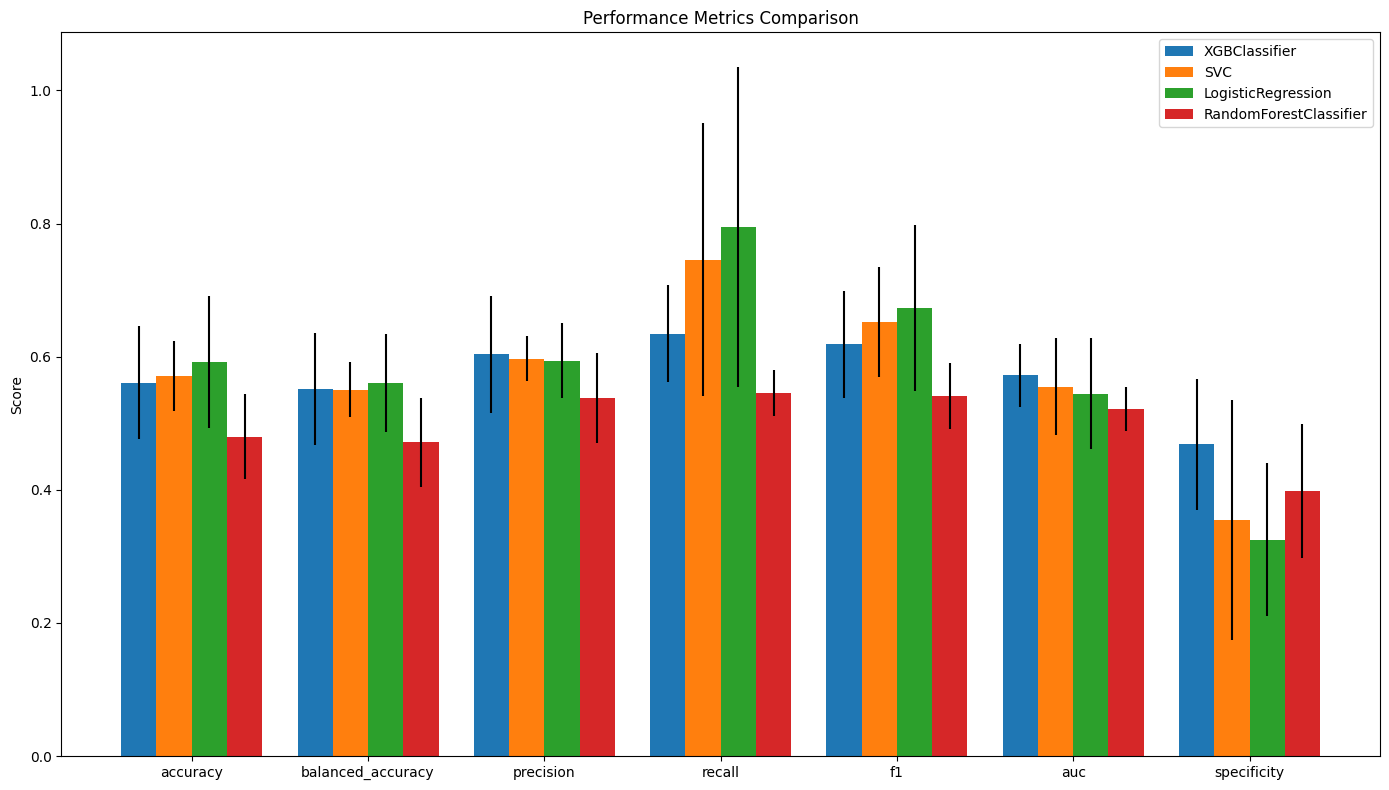

,accuracy,balanced_accuracy,precision,recall,f1,auc,specificity
model,,,,,,,
LogisticRegression,0.592083,0.560165,0.594081,0.795330,0.673805,0.544693,0.325000
RandomForestClassifier,0.480000,0.471528,0.538370,0.545330,0.541325,0.521279,0.397727
SVC,0.571250,0.550212,0.597213,0.745879,0.652106,0.555045,0.354545
XGBClassifier,0.561250,0.551399,0.603571,0.634615,0.618546,0.572059,0.468182


In [112]:
dataset = 'demographic'
importances_added = False  # Prevents printing for every fold
print('dataset:', dataset)

# Assuming df_digital_tmt_with_target is already defined
match dataset:
    case 'demographic':
        X = demographic_df.iloc[:, :-1].values
        y = demographic_df.iloc[:, -1].values
        feature_names = demographic_df.columns[:-1]
    case 'non_digital_tests':
        X = non_digital_df.iloc[:, :-1].values
        y = non_digital_df.iloc[:, -1].values
        feature_names = non_digital_df.columns[:-1]
    case 'digital_test':
        X = df_digital_tmt_with_target.iloc[:, :-1].values
        y = df_digital_tmt_with_target.iloc[:, -1].values
        feature_names = df_digital_tmt_with_target.columns[:-1]
    case _:
        raise ValueError('please select a valid dataset [`demographic`, `non_digital_tests` or `digital_test`]')

n_importances = 15

# Print class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

# Define parameter grids
param_grids = {
    "RandomForestClassifier": {
        "classifier__n_estimators": [100, 500, 700, 1000],
        "classifier__max_depth": [None, 10, 20, 30]
    },
    "SVC": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ['linear', 'rbf']
    },
    "LogisticRegression": {
        "classifier__C": [0.1, 1, 10],
        "classifier__penalty": ['l2']
    },
    "XGBClassifier": {
        "classifier__n_estimators": [100, 300],
        "classifier__max_depth": [3, 5],
        "classifier__learning_rate": [0.05, 0.1]
    }
}

# Define models to evaluate
models = [
    RandomForestClassifier(random_state=42),
    SVC(random_state=42, probability=True),
    LogisticRegression(max_iter=1000, random_state=42),
    xgb.XGBClassifier(random_state=42, tree_method="hist", eval_metric='logloss')
]

# Set up outer CV
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)

# Create a DataFrame to store all metrics for all models
all_metrics_df = pd.DataFrame(columns=[
    'model', 'fold', 'accuracy', 'balanced_accuracy', 'precision', 
    'recall', 'f1', 'auc', 'specificity'
])


# Perform nested CV for each model
for model in models:
    model_name = model.__class__.__name__
    print(f"\n🧪 Nested CV for: {model_name}")
    
    # Results for this model
    tprs = []
    aucs = []
    best_params_list = []
    selected_features = []
    
    # Reset feature importance counts for this model
    feature_importance_counts = {name: 0 for name in feature_names}
    
    # Metrics for this model
    fold_metrics = []
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    all_y_true = []
    all_y_pred = []

    best_models = []
    # Outer CV loop
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            # ('feature_selection', RFE(estimator=LogisticRegression(max_iter=1000), 
            #                          n_features_to_select=n_importances)),
            ('classifier', model)
        ])
        
        # Set up grid search with inner CV
        param_grid = param_grids.get(model_name, {})
        
        # Use AUC as the primary scoring metric for optimization
        grid = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=3,  # inner CV
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1  # Show progress
        )
        
        # Train on the current fold
        grid.fit(X_train, y_train)
        
        # Store best parameters
        best_params_list.append(grid.best_params_)
        
        # Get the best model from GridSearchCV
        best_model = grid.best_estimator_
        best_models.append(best_model)

        
        # # Track selected features
        # feature_selector = best_model.named_steps['feature_selection']
        # selected_mask = feature_selector.support_
        # fold_selected_features = feature_names[selected_mask]
        # selected_features.append(fold_selected_features)
        
        # # Update feature importance counts
        # for feature in fold_selected_features:
        #     feature_importance_counts[feature] += 1
        
        # Generate ROC curve
        viz = RocCurveDisplay.from_estimator(
            best_model,
            X_test,
            y_test,
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == outer_cv.get_n_splits() - 1),
        )
        
        # Get predicted probabilities and classes
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        y_pred = best_model.predict(X_test)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

        
        # Calculate various metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        
        metrics = {
            'model': model_name,
            'fold': fold,
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred_proba),
            'specificity': specificity
        }
        
        fold_metrics.append(metrics)
        all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics])], ignore_index=True)
        
        # Interpolate TPR for mean ROC
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    
    # Calculate mean ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plot mean ROC
    ax.plot(mean_fpr, mean_tpr, color="b",
            label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
            lw=2, alpha=0.8)
    
    std_tpr = np.std(tprs, axis=0)
    ax.fill_between(mean_fpr,
                    np.maximum(mean_tpr - std_tpr, 0),
                    np.minimum(mean_tpr + std_tpr, 1),
                    color="grey", alpha=0.2,
                    label=r"$\pm$ 1 std. dev.")
    
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate",
           title=f"Dataset: {dataset}\nMean ROC curve with Nested CV - {model_name}")
    ax.legend(loc="lower right")
    plt.show()
    
    # Print best params from each fold
    print(f"🔧 Best hyperparameters across folds for {model_name}:")
    for i, params in enumerate(best_params_list):
        print(f"  Fold {i}: {params}")
    

    # Calculate and print mean metrics across folds
    model_metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = model_metrics_df.mean(numeric_only=True)
    std_metrics = model_metrics_df.std(numeric_only=True)
    
    # Plot confusion matrix (average across folds)
    plt.figure(figsize=(6, 5))
    cm_df = pd.DataFrame(fold_metrics)[['fold', 'model']].copy()
    cm_df['TP'] = 0
    cm_df['FP'] = 0
    cm_df['TN'] = 0
    cm_df['FN'] = 0
    
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_test = X[test_idx]
        y_test = y[test_idx]
        best_model = grid.best_estimator_  # Using the last trained model
        y_pred = best_model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        cm_df.loc[fold, ['TP', 'FP', 'TN', 'FN']] = [tp, fp, tn, fn]

    
    # avg_cm = np.array([
    #     [cm_df['TN'].mean(), cm_df['FP'].mean()],
    #     [cm_df['FN'].mean(), cm_df['TP'].mean()]
    # ])
    
    # sns.heatmap(avg_cm, annot=True, fmt='.1f', cmap='Blues',
    #             xticklabels=['Negative', 'Positive'],
    #             yticklabels=['Negative', 'Positive'])
    # plt.title(f'Average Confusion Matrix - {model_name}')
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.show()

    global_cm = confusion_matrix(all_y_true, all_y_pred)

    # Optional: print the matrix
    print("🔢 Global Confusion Matrix (all folds combined):")
    print(global_cm)

    # Optional: plot the matrix
    ConfusionMatrixDisplay(global_cm, display_labels=['Negative', 'Positive']).plot(cmap='Blues')
    plt.title(f'Global Confusion Matrix - {model_name}')
    plt.show()
    
    # Plot feature importances for RandomForestClassifier
    if model_name == "RandomForestClassifier":
        # For RandomForest, we can get feature importances directly
        # We'll use the feature importances from the last fold's best model
        best_model = grid.best_estimator_
        
        # # Get the feature selector to identify which features were selected
        # feature_selector = best_model.named_steps['feature_selection']
        # selected_mask = feature_selector.support_
        
        # Get the RandomForest classifier from the pipeline
        rf_classifier = best_model.named_steps['classifier']
        
        # Get importances for the selected features
        importances = rf_classifier.feature_importances_
        
        # Get names of the selected features
        # selected_feature_names = feature_names[selected_mask]
        
        # Sort features by importance
        indices = np.argsort(importances)[::-1]
        
        # Take top N features
        top_indices = indices[:n_importances]
        
        # Get corresponding names and importance values
        # top_features = selected_feature_names[top_indices]
        top_importances = importances[top_indices]
        
        # Plot
        fig2, ax2 = plt.subplots(figsize=(10, 6))
        ax2.barh(range(len(top_indices)), top_importances[::-1], align='center')
        ax2.set_yticks(range(len(top_indices)))
        ax2.set_yticklabels(feature_names[top_indices])
        ax2.set_xlabel("Feature Importance")
        ax2.set_title(f"Top {n_importances} Feature Importances - {model_name}")
        plt.tight_layout()
        plt.show()

# Compare metrics across models
print("\n🏆 Model Performance Comparison:")
metrics_comparison = all_metrics_df.groupby('model').mean(numeric_only=True)
metrics_std = all_metrics_df.groupby('model').std(numeric_only=True)

# Print formatted comparison
for metric in ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'auc', 'specificity']:
    print(f"\n{metric.upper()}:")
    for model_name in metrics_comparison.index:
        print(f"  {model_name}: {metrics_comparison.loc[model_name, metric]:.3f} ± "
              f"{metrics_std.loc[model_name, metric]:.3f}")

# Create a visual comparison of models across metrics
plt.figure(figsize=(14, 8))

metrics_to_plot = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'auc', 'specificity']
x = np.arange(len(metrics_to_plot))
width = 0.2
n_models = len(models)
offsets = np.linspace(-(width * (n_models-1))/2, (width * (n_models-1))/2, n_models)

for i, model_name in enumerate(metrics_comparison.sort_values('auc', ascending=False).index):
    heights = [metrics_comparison.loc[model_name, m] for m in metrics_to_plot]
    errors = [metrics_std.loc[model_name, m] for m in metrics_to_plot]
    plt.bar(x + offsets[i], heights, width, yerr=errors, label=model_name)

plt.xticks(x, metrics_to_plot)
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.legend()
plt.tight_layout()
plt.show()




metrics_comparison